# Import danych

In [56]:
import os
import librosa
import IPython.display as ipd
import matplotlib.pyplot as plt
import numpy as np
from scipy.io import wavfile
import warnings
import random
from sklearn.preprocessing import LabelEncoder
from keras.utils import np_utils
from sklearn.model_selection import train_test_split
from keras.layers import Dense, Dropout, Flatten, Conv1D, Input, MaxPooling1D
from keras.models import Model
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras import backend as K
from matplotlib import pyplot
from sklearn.utils import shuffle

warnings.filterwarnings("ignore")

In [57]:
train_audio_path = 'input/train/audio/'


# Funkcje

## Wykres diagnostczny

In [58]:
def plotDiagnosticChart(history):
  pyplot.plot(history.history['loss'], label='train')
  pyplot.plot(history.history['val_loss'], label='test')
  pyplot.legend()
  pyplot.show()

## Wybór zbioru treningowego i walidacyjnego

In [59]:
def getTrainAndValidationSet(all_wave,y):
  return train_test_split(np.array(all_wave),np.array(y),stratify=y,test_size = 0.2,random_state=777,shuffle=True)

## Trening i testowaie na zbiorze walidacyjnym

In [60]:
def trainAndTest(model,x_tr,y_tr,x_val,y_val,es,mc):
  history=model.fit(x_tr, y_tr ,epochs=100, callbacks=[es,mc], batch_size=32, validation_data=(x_val,y_val))
  return history

# Wybór 5 słów i preprocessing

## Wylosowanie 5 słów

Losowo wybrane 5 słów

In [71]:
random_labels = random.choices(os.listdir(train_audio_path),k=5)
print(random_labels)

['two', 'nine', 'sheila', 'go', 'marvin']


Ilość nagrań dla wybranych 5 słów

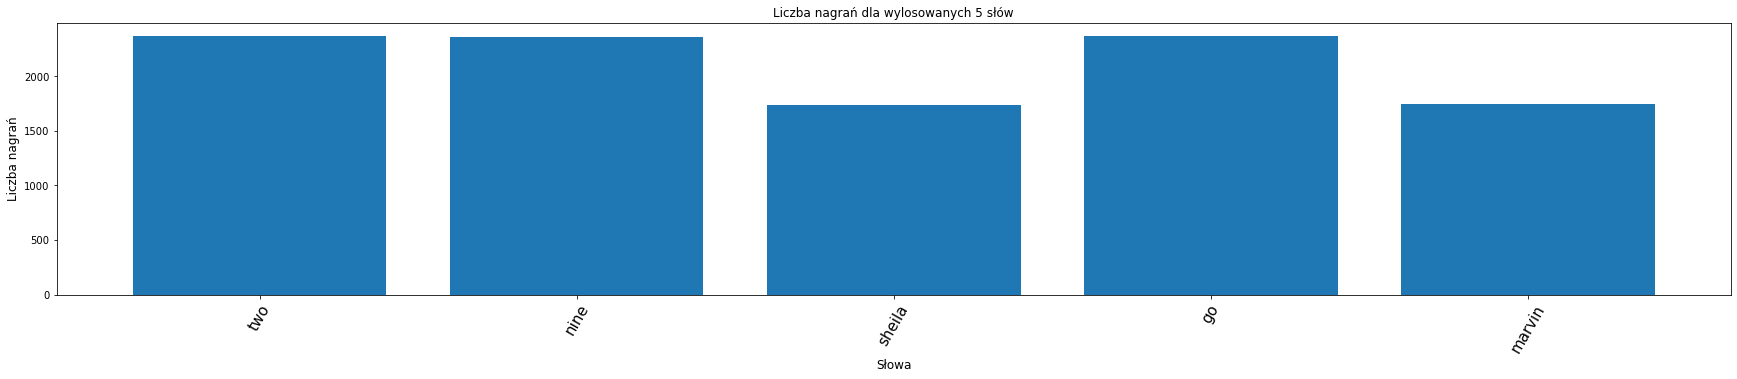

In [72]:
no_of_recordings=[]
for label in random_labels:
    waves = [f for f in os.listdir(train_audio_path + '/'+ label) if f.endswith('.wav')]
    no_of_recordings.append(len(waves))
    
plt.figure(figsize=(30,5))
index = np.arange(len(random_labels))
plt.bar(index, no_of_recordings)
plt.xlabel('Słowa', fontsize=12)
plt.ylabel('Liczba nagrań', fontsize=12)
plt.xticks(index, random_labels, fontsize=15, rotation=60)
plt.title('Liczba nagrań dla wylosowanych 5 słów')
plt.show()

## Preprocessing

Resampling nagrań o długości 1s do częstotliwości 8 tys HZ 

In [73]:
all_wave = []
all_label = []
for label in random_labels:
    print(label)
    waves = [f for f in os.listdir(train_audio_path + '/'+ label) if f.endswith('.wav')]
    for wav in waves:
        samples, sample_rate = librosa.load(train_audio_path + '/' + label + '/' + wav, sr = 16000)
        samples = librosa.resample(samples, sample_rate, 8000)
        if(len(samples)== 8000) : 
            all_wave.append(samples)
            all_label.append(label)

two
nine
sheila
go
marvin


In [74]:
%store all_wave
%store all_label

Stored 'all_wave' (list)
Stored 'all_label' (list)


Konwersja etykiet tekstowych do kodów całkowitoliczbowych

In [75]:
le = LabelEncoder()
y=le.fit_transform(all_label)
classes= list(le.classes_)

 Konwersja całkowitoliczbowych etykiet do jednego wektora



In [76]:
y=np_utils.to_categorical(y, num_classes=len(random_labels))

# Sieć

Budowa modelu

In [77]:
def createModel():
  K.clear_session()
  inputs = Input(shape=(8000,1))

  #First Conv1D layer
  conv = Conv1D(8,13, padding='valid', activation='relu', strides=1)(inputs)
  conv = MaxPooling1D(3)(conv)
  conv = Dropout(0.3)(conv)

  #Second Conv1D layer
  conv = Conv1D(16, 11, padding='valid', activation='relu', strides=1)(conv)
  conv = MaxPooling1D(3)(conv)
  conv = Dropout(0.3)(conv)

  #Third Conv1D layer
  conv = Conv1D(32, 9, padding='valid', activation='relu', strides=1)(conv)
  conv = MaxPooling1D(3)(conv)
  conv = Dropout(0.3)(conv)

  #Fourth Conv1D layer
  conv = Conv1D(64, 7, padding='valid', activation='relu', strides=1)(conv)
  conv = MaxPooling1D(3)(conv)
  conv = Dropout(0.3)(conv)

  #Flatten layer
  conv = Flatten()(conv)

  #Dense Layer 1
  conv = Dense(256, activation='relu')(conv)
  conv = Dropout(0.3)(conv)

  #Dense Layer 2
  conv = Dense(128, activation='relu')(conv)
  conv = Dropout(0.3)(conv)

  outputs = Dense(len(random_labels), activation='softmax')(conv)

  model = Model(inputs, outputs)
  model.summary()

  model.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['accuracy'])

  return model

In [78]:
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=10, min_delta=0.0001) 
mc = ModelCheckpoint('best_model.hdf5', monitor='val_acc', verbose=1, save_best_only=True, mode='max')

# Zadanie 1

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 8000, 1)]         0         
_________________________________________________________________
conv1d (Conv1D)              (None, 7988, 8)           112       
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 2662, 8)           0         
_________________________________________________________________
dropout (Dropout)            (None, 2662, 8)           0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 2652, 16)          1424      
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 884, 16)           0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 884, 16)           0     

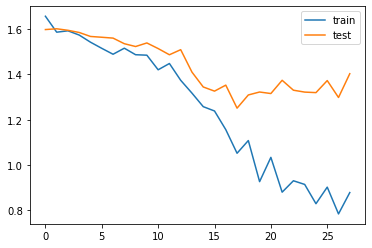

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 8000, 1)]         0         
_________________________________________________________________
conv1d (Conv1D)              (None, 7988, 8)           112       
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 2662, 8)           0         
_________________________________________________________________
dropout (Dropout)            (None, 2662, 8)           0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 2652, 16)          1424      
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 884, 16)           0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 884, 16)           0     

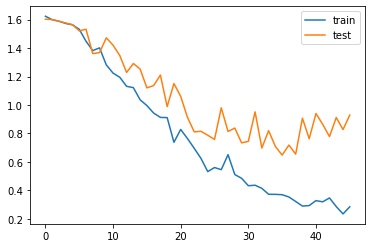

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 8000, 1)]         0         
_________________________________________________________________
conv1d (Conv1D)              (None, 7988, 8)           112       
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 2662, 8)           0         
_________________________________________________________________
dropout (Dropout)            (None, 2662, 8)           0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 2652, 16)          1424      
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 884, 16)           0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 884, 16)           0     

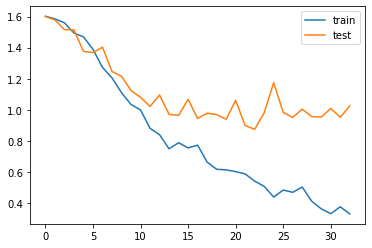

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 8000, 1)]         0         
_________________________________________________________________
conv1d (Conv1D)              (None, 7988, 8)           112       
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 2662, 8)           0         
_________________________________________________________________
dropout (Dropout)            (None, 2662, 8)           0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 2652, 16)          1424      
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 884, 16)           0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 884, 16)           0     

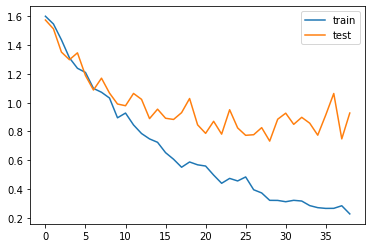

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 8000, 1)]         0         
_________________________________________________________________
conv1d (Conv1D)              (None, 7988, 8)           112       
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 2662, 8)           0         
_________________________________________________________________
dropout (Dropout)            (None, 2662, 8)           0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 2652, 16)          1424      
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 884, 16)           0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 884, 16)           0     

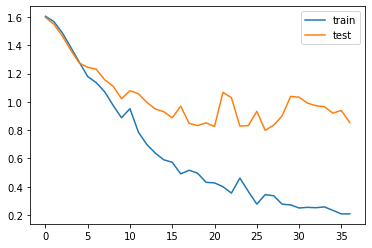

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 8000, 1)]         0         
_________________________________________________________________
conv1d (Conv1D)              (None, 7988, 8)           112       
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 2662, 8)           0         
_________________________________________________________________
dropout (Dropout)            (None, 2662, 8)           0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 2652, 16)          1424      
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 884, 16)           0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 884, 16)           0     

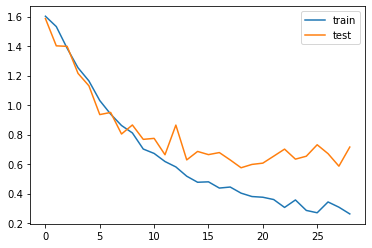

In [79]:
trained_models = []
all_wave = np.array(all_wave)

all_wave, y = shuffle(all_wave, y)

for size in range(300,2000,300):
  new_model = createModel()

  print('Rozmiar zbioru treningowego: ' + str(size))
  wav = all_wave[:size,:]
  new_y = y[:size,:]
  wav = np.array(wav).reshape(-1,8000,1)

  x_tr, x_val, y_tr, y_val = getTrainAndValidationSet(wav,new_y)
  history = trainAndTest(new_model,x_tr,y_tr,x_val,y_val,es,mc)
  plotDiagnosticChart(history)

  trained_models.append(new_model)



## Zadanie 2

Z zadania 1 widzimy że dla dobrej dokładności (powyżej 60%) 300 próbek na pewno nie wystarczy. Wyniki dla modelu z zadania 1 dla 300 próbek: val_loss: 1.1630 - val_accuracy: 0.5500 

In [80]:
random_labels = random.choices(os.listdir(train_audio_path),k=5)
print(random_labels)

['happy', 'marvin', 'on', 'one', 'wow']


In [81]:
all_wave = []
all_label = []
for label in random_labels:
    print(label)
    waves = [f for f in os.listdir(train_audio_path + '/'+ label) if f.endswith('.wav')]
    for wav in waves:
        samples, sample_rate = librosa.load(train_audio_path + '/' + label + '/' + wav, sr = 16000)
        samples = librosa.resample(samples, sample_rate, 8000)
        if(len(samples)== 8000) : 
            all_wave.append(samples)
            all_label.append(label)

happy
marvin
on
one
wow


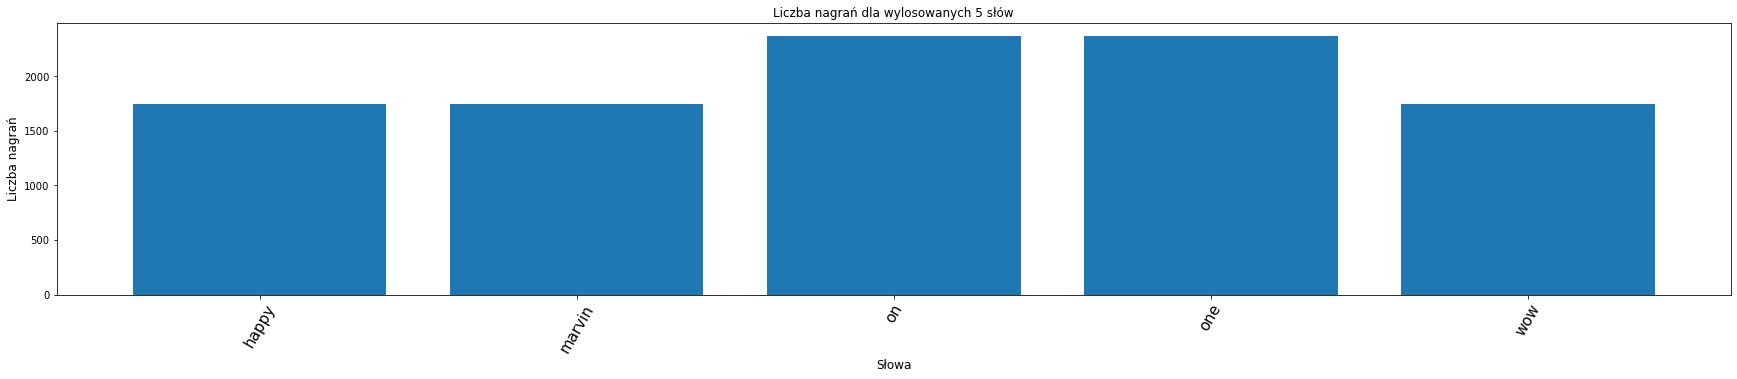

In [82]:
no_of_recordings=[]
for label in random_labels:
    waves = [f for f in os.listdir(train_audio_path + '/'+ label) if f.endswith('.wav')]
    no_of_recordings.append(len(waves))
    
plt.figure(figsize=(30,5))
index = np.arange(len(random_labels))
plt.bar(index, no_of_recordings)
plt.xlabel('Słowa', fontsize=12)
plt.ylabel('Liczba nagrań', fontsize=12)
plt.xticks(index, random_labels, fontsize=15, rotation=60)
plt.title('Liczba nagrań dla wylosowanych 5 słów')
plt.show()

In [83]:
le = LabelEncoder()
y=le.fit_transform(all_label)
classes= list(le.classes_)

In [84]:
y=np_utils.to_categorical(y, num_classes=len(random_labels))

In [85]:
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=10, min_delta=0.0001) 
mc = ModelCheckpoint('best_model2.hdf5', monitor='val_acc', verbose=1, save_best_only=True, mode='max')


A) Zamrozić wszystkie warstwy konwolucyjne modelu z zadania na dst i przetrenować na nowym zbiorze tylko warstwy gęste (pierwsza metoda transfer learning)

In [86]:
new_model = createModel()
K.clear_session()
inputs = Input(shape=(8000,1))

# #First Conv1D layer
# conv = Conv1D(8,13, padding='valid', activation='relu', strides=1)(inputs)
# conv = MaxPooling1D(3)(conv)
# conv = Dropout(0.3)(conv)

# #Second Conv1D layer
# conv = Conv1D(16, 11, padding='valid', activation='relu', strides=1)(conv)
# conv = MaxPooling1D(3)(conv)
# conv = Dropout(0.3)(conv)

# #Third Conv1D layer
# conv = Conv1D(32, 9, padding='valid', activation='relu', strides=1)(conv)
# conv = MaxPooling1D(3)(conv)
# conv = Dropout(0.3)(conv)

# #Fourth Conv1D layer
# conv = Conv1D(64, 7, padding='valid', activation='relu', strides=1)(conv)
# conv = MaxPooling1D(3)(conv)
# conv = Dropout(0.3)(conv)

#Flatten layer
conv = Flatten()(inputs)

#Dense Layer 1
conv = Dense(256, activation='relu')(conv)
conv = Dropout(0.3)(conv)

#Dense Layer 2
conv = Dense(128, activation='relu')(conv)
conv = Dropout(0.3)(conv)

outputs = Dense(len(random_labels), activation='softmax')(conv)

model = Model(inputs, outputs)
model.summary()

model.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['accuracy'])


Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 8000, 1)]         0         
_________________________________________________________________
conv1d (Conv1D)              (None, 7988, 8)           112       
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 2662, 8)           0         
_________________________________________________________________
dropout (Dropout)            (None, 2662, 8)           0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 2652, 16)          1424      
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 884, 16)           0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 884, 16)           0     

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 8000, 1)]         0         
_________________________________________________________________
conv1d (Conv1D)              (None, 7988, 8)           112       
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 2662, 8)           0         
_________________________________________________________________
dropout (Dropout)            (None, 2662, 8)           0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 2652, 16)          1424      
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 884, 16)           0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 884, 16)           0     

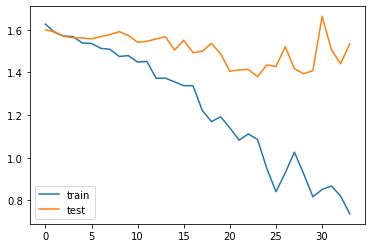

In [87]:

all_wave = np.array(all_wave)

all_wave, y = shuffle(all_wave, y)
size=300
new_model = createModel()

print('Rozmiar zbioru treningowego: ' + str(size))
wav = all_wave[:size,:]
new_y = y[:size,:]
wav = np.array(wav).reshape(-1,8000,1)

x_tr, x_val, y_tr, y_val = getTrainAndValidationSet(wav,new_y)
history = trainAndTest(new_model,x_tr,y_tr,x_val,y_val,es,mc)
plotDiagnosticChart(history)

trained_models.append(new_model)